In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
from sklearn import linear_model
from sklearn import model_selection 
import gc

In [12]:
# import initial image and metrics data
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7 
    
img =cv2.imread('random_7_final_crop_masks.tif') #segmented and eroded image
metrics=pd.read_csv('exported_metrics_new.csv')

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7


In [25]:
#calculate density, del and del^2 of regions given a window size
window_radius=[100, 250, 400, 500, 600, 750, 1000]
y=metrics.to_numpy()[:,0]
cx=metrics.to_numpy()[:,3]
cy=metrics.to_numpy()[:,4]
# Find Canny edges
edged = cv2.Canny(img, 30, 200)

contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

number_mat=np.zeros([np.shape(cx)[0],np.size(window_radius)])
density=np.zeros([np.shape(cx)[0],np.size(window_radius)])
grad=np.zeros([np.shape(cx)[0],np.size(window_radius)])
for ii in range(np.shape(cx)[0]):

    repe=np.repeat([[cx[ii],cy[ii]]],np.shape(cx)[0], axis=0)
    dist=np.sqrt((cx[:]-repe[:,0])**2+(cy[:]-repe[:,1])**2)
    for jj in range(np.size(window_radius)):
        number=np.size(np.argwhere(dist<window_radius[jj])) #include self?
        
        number_mat[ii,jj]=number
        density[ii,jj]=number/(np.pi*window_radius[jj]**2)*100**2
        #grad[ii,jj]=1/(np.max(dist[np.argwhere(dist<window_radius[jj])]))
'''
ok=0       
while ok==0:    
    alpha=np.random.rand(1)
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(density, y)
    if np.size(np.where(clf.coef_!=0))==3:
        ok=1
'''

model = linear_model.Lasso()
# define model evaluation method
cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 0.1, 0.0001)
# define search
search = model_selection.GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(density, y)
print(results.best_params_)   

alpha=0.0004
clf = linear_model.Lasso(alpha=alpha)
clf.fit(density, y)
print(clf.coef_)

{'alpha': 0.0004}
[0.         0.12575606 0.14344557 0.         0.         0.
 0.        ]


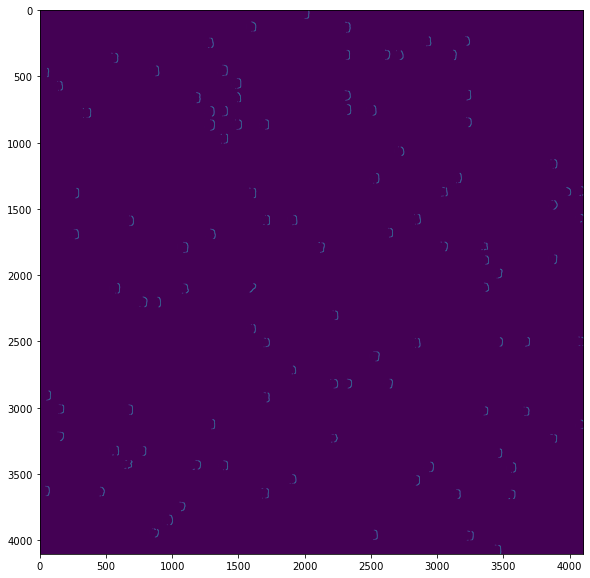

In [49]:
img =cv2.imread('random_7_init_crop_masks.tif')
img[img==255]=1
np.array(img)
img_sobel=ndimage.sobel(img[:,:,0])
plt.figure(figsize=(10,10))
plt.imshow(img_sobel)

In [42]:
a=np.random.randint(2,size=[5,5])
ndimage.sobel(a)

array([[-1, -4, -2,  4,  3],
       [-1, -3,  0,  4,  2],
       [ 1, -1,  0,  3,  1],
       [ 1,  0,  2,  2, -1],
       [ 0,  0,  4,  3, -1]])

In [47]:
np.array(img)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)